In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [3]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### Read in articles from JSON

In [5]:
articles_spark = spark.read.json('gs://msca-bdp-data-open/news/news_university.json')
articles_spark.count()

57500

In [6]:
articles_spark.limit(5)

author,crawled,entities,external_links,highlightText,highlightTitle,language,ord_in_thread,published,rating,text,thread,title,url,uuid
Jackie Harper (no...,2018-01-22T06:31:...,"[[[detroit, none]...",[],,,english,0,2018-01-22T05:30:...,null,FREE public plane...,"[US,,, 1, 0, 2018...",FREE public plane...,http://omgili.com...,9fefb15f4fd9ae09a...
n0lifeismylife,2018-01-22T06:31:...,"[[], [], []]",[],,,english,0,2018-01-22T01:12:...,null,submitted by /u/n...,"[US, 33, , 10, 0,...",A computer Scienc...,http://omgili.com...,4a2a0e21f3f4887f2...
redaintded,2018-01-22T06:31:...,"[[], [], []]",[],,,english,0,2018-01-21T17:52:...,null,that went undefea...,"[US, 3057, , 8, 0...",Whos the Greatest...,http://omgili.com...,90a0680ec2be19eb5...
Manoj Pandey (nor...,2018-01-22T06:31:...,"[[], [], [[vivek ...",[],,,english,0,2018-01-22T06:31:...,null,,"[US,,, 1, 0, 2018...",FULL HD VIDEO || ...,http://omgili.com...,752253f9643965cf5...
vision Arts (nore...,2018-01-22T06:32:...,"[[], [[newborn ph...",[],,,english,0,2018-01-22T06:32:...,null,By Sharon Wagner ...,"[US,,, 1, 0, 2018...",Tips For Newborn ...,http://omgili.com...,f4eae633665cbd519...


Take just the title column, since that is the bit of text that we will be using for our similarity analysis.

In [6]:
titles_df_raw = articles_spark.select(["title"]).withColumnRenamed('title', 'text')
titles_df_raw.printSchema()

root
 |-- text: string (nullable = true)



### Process text data: filter out empty values, tokenize (remove stopwords, non-alphanumeric characters, short words)

In [8]:
titles_df_raw.limit(5)

text
FREE public plane...
A computer Scienc...
Whos the Greatest...
FULL HD VIDEO || ...
Tips For Newborn ...


In [9]:
titles_df_raw.filter(titles_df_raw.text.isNull()).count()

0

In [7]:
# remove None values
text = titles_df_raw.filter(titles_df_raw.text.isNotNull())

text = titles_df_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

# store stop words
StopWords = stopwords.words("english")


# tokenize data: 
# convert each title to lowercase, split it on whitespace 
# for each word in title: keep only alphanumeric characters, non-stop words, and tokens longer than 3 characters

tokens = text\
.map( lambda document: document.strip().lower())\
.map( lambda document: re.split(" ", document))\
.map( lambda word: [x for x in word if x.isalnum()])\
.map( lambda word: [x for x in word if x not in StopWords])\
.map( lambda word: [x for x in word if len(x) > 3] )\
.zipWithIndex()

In [8]:
# Row object from Spark DF
row = Row('text')
text_df = text.map(row).zipWithIndex().toDF(['text','id'])

text_df.limit(5)

text,id
[FREE public plan...,0
[A computer Scien...,1
[Whos the Greates...,2
[FULL HD VIDEO ||...,3
[Tips For Newborn...,4


In [9]:
text_df.printSchema()

root
 |-- text: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |-- id: long (nullable = true)



Confirm size.

The original size of the frame is maintained, so we must not have had any null values.


Create a dataframe with two columns: one whose values are arrays of individual tokens from each article title, and one who value is the index of the title.

In [10]:
tokens_df = spark.createDataFrame(tokens, ["list_of_words",'id'])

# drop records with no tokens
tokens_df = tokens_df.where(col('list_of_words').getItem(0).isNotNull())

# display first 5 rows as a pandas dataframe
tokens_df.limit(5).toPandas()

,list_of_words,id
0,"[free, public, planetarium, shows, wayne, state, university, planetarium, rsvp]",0
1,"[computer, science, professor, university, sent, email]",1
2,"[whos, greatest, college, football, team, ever]",2
3,"[full, video, college, aabelu, vivek, dubey]",3
4,"[tips, newborn, photography, college, station]",4


### Fit CountVectorizer to create word feature arrays for each title

In [11]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)

df_vectorize = vectorize.fit(tokens_df).transform(tokens_df)

In [15]:
text_df.limit(5)

text,id
[FREE public plan...,0
[A computer Scien...,1
[Whos the Greates...,2
[FULL HD VIDEO ||...,3
[Tips For Newborn...,4


In [12]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[free, public, planetarium, shows, wayne, state, university, planetarium, rsvp]",0,"(0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[computer, science, professor, university, sent, email]",1,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[whos, greatest, college, football, team, ever]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[full, video, college, aabelu, vivek, dubey]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[tips, newborn, photography, college, station]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


### Fit MinHashLSH to create hash table

In [13]:
min_hash = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=3)
model = min_hash.fit(df_vectorize)
hashed_df = min_hash.fit(df_vectorize).transform(df_vectorize).cache()

In [18]:
hashed_df.limit(5)

list_of_words,id,features,hashes
"[free, public, pl...",0,"(28959,[1,2,18,84...","[[4.08246304E8], ..."
"[computer, scienc...",1,"(28959,[1,35,75,4...","[[1.04460723E8], ..."
"[whos, greatest, ...",2,"(28959,[0,12,76,8...","[[4.7945584E7], [..."
"[full, video, col...",3,"(28959,[0,169,203...","[[4.7945584E7], [..."
"[tips, newborn, p...",4,"(28959,[0,300,305...","[[4.7945584E7], [..."


In [14]:
hashed_text_df = text_df.join(hashed_df, on="id", how = 'left')

In [15]:
hashed_text_df.cache()

id,text,list_of_words,features,hashes
26,[New Headmaster J...,"[headmaster, join...","(28959,[0,5,162,3...","[[4.7945584E7], [..."
29,[College track an...,"[college, track, ...","(28959,[0,559,191...","[[4.7945584E7], [..."
474,[thirumurugan gan...,"[thirumurugan, ga...","(28959,[0,127,154...","[[4.7945584E7], [..."
964,[Edward Waters Co...,"[edward, waters, ...","(28959,[0,110,202...","[[4.7945584E7], [..."
1677,[Community colleg...,"[community, colle...","(28959,[0,15,50,3...","[[4.7945584E7], [..."
1697,[[Once-great Brit...,"[britain, explodi...","(28959,[42,86,133...","[[2.1725789E7], [..."
1806,[Measles case at ...,"[measles, case, i...","(28959,[1,194,358...","[[2.44739512E8], ..."
1950,[Oregon college s...,"[oregon, college,...","(28959,[0,278,393...","[[4.7945584E7], [..."
2040,[Gipson’s Career ...,"[career, lifts, g...","(28959,[0,6,196,2...","[[4.7945584E7], [..."
2214,[e-Headlines – Co...,"[community, colle...","(28959,[0,15,210]...","[[4.7945584E7], [..."


In [16]:
hashed_text_df.limit(5)

id,text,list_of_words,features,hashes
26,[New Headmaster J...,"[headmaster, join...","(28959,[0,5,162,3...","[[4.7945584E7], [..."
29,[College track an...,"[college, track, ...","(28959,[0,559,191...","[[4.7945584E7], [..."
474,[thirumurugan gan...,"[thirumurugan, ga...","(28959,[0,127,154...","[[4.7945584E7], [..."
964,[Edward Waters Co...,"[edward, waters, ...","(28959,[0,110,202...","[[4.7945584E7], [..."
1677,[Community colleg...,"[community, colle...","(28959,[0,15,50,3...","[[4.7945584E7], [..."


In [17]:
hashed_df.unpersist();

### Try different Jaccard similarity thresholds, examine results

#### Jaccard distance of 0.3 (similarity of at least 0.7)

In [30]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(hashed_text_df, hashed_text_df, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol").alias("jacc_distance"),
            col("datasetA.id").alias("text_id_A"),
            col("datasetB.id").alias("text_id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [31]:
df_dups_30 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,jacc_distance,text_id_A,text_id_B,text_A,text_B
0,0.00,1473,2482,"(University of Kansas group wants school to sell jet,)","(University of Kansas Group Wants School to Sell Jet,)"
1,0.00,16868,16989,"(State AG: Michigan State University Under Investigation In Ongoing Nassar Fallout,)","(State AG: Michigan State University Under Investigation In Ongoing Nassar Fallout,)"
2,0.25,17427,26976,"(Google Alert - college,)","(Google Alert - college football,)"
3,0.25,17427,53740,"(Google Alert - college,)","(Google Alert - college football,)"
4,0.25,17427,24809,"(Google Alert - college,)","(Google Alert - college football,)"


Article titles with Jaccard distance of 0 are duplicates -- (their similarity is 1.0). The first few rows shown above are different articles (with unique IDs) but are actually duplicates of each other.

In [32]:
records = hashed_text_df.count()
dups = df_dups_text.select('text_id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  57500
Duplicate titles based on { 0.3 } jaccard distance:  20113
Unique titles based on { 0.3 } jaccard distance:  0.3 :  37387


Create bar chart showing values of unique versus near duplicates.

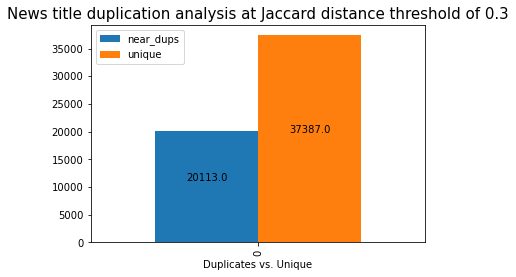

In [34]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind ='bar', y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis at Jaccard distance threshold of 0.3', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

**When the distance threshold is 0.3, we see nearly double the number of unique article pairs than duplicates.** At 0.3, we're saying that pairs have to have at least 0.7 similarity, which is fairly high so this result is not unsurprising.

Create histogram of near-duplication (I understood this to mean the following: a histogram showing distribution of Jaccard distance values for those pairs that were called dups by our algorithm).

In [39]:
df_dups_text.select('jacc_distance', 'text_id_A').dropDuplicates(['text_id_A']).count()

20117

In [40]:
jacc_dist_scores = df_dups_text.select('jacc_distance', 'text_id_A').dropDuplicates(['text_id_A']).toPandas()
jacc_dist_scores.head()

,jacc_distance,text_id_A
0,0.00,2214
1,0.00,4590
2,0.00,7225
3,0.00,32571
4,0.25,32954


In [41]:
jacc_dist_scores.shape

(20117, 2)

In [42]:
jacc_dist_scores.describe()

,jacc_distance,text_id_A
count,20117.000000,20117.000000
mean,0.067858,27422.828404
std,0.103882,16042.881814
min,0.000000,4.000000
25%,0.000000,13588.000000
50%,0.000000,26919.000000
75%,0.166667,40894.000000
max,0.294118,57471.000000


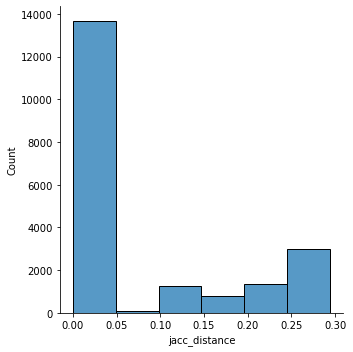

In [47]:
sns.displot(jacc_dist_scores, x='jacc_distance', bins=6)

We can see that of the duplicate pairs, the overwhelming majority of them have very low distance scores between 0.00 and 0.05 (again, meaning that they're very similar to each other). It's therefore **unlikely that raising the threshold, say from 0.3 to 0.5, will do too much to impact the counts of duplicates versus unique.**

We can try 0.5 just to confirm, however. Additionally, since the text we're comparing is the titles of the news articles, not the full articles, and are therefore shorter documents (in number of word tokens), I think it **makes sense to keep the threshold for similarity fairly high (at 0.3).**

#### Jaccard distance of 0.5 (similarity of at least 0.5)

In [18]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(hashed_text_df, hashed_text_df, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol").alias("jacc_distance"),
            col("datasetA.id").alias("text_id_A"),
            col("datasetB.id").alias("text_id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [49]:
df_dups_text.unpersist();

In [19]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,jacc_distance,text_id_A,text_id_B,text_A,text_B
0,0.00,7350,7760,"(Google Alert - university,)","(Google Alert - university,)"
1,0.40,8368,9249,"(Michigan State University president resigns after Nassar sentencing,)","(Michigan State University president resigns amid Larry Nassar scandal,)"
2,0.25,8485,42288,"(Google Alert - college,)","(Google Alert - college football,)"
3,0.25,8485,40864,"(Google Alert - college,)","(Google Alert - college football,)"
4,0.25,8485,50197,"(Google Alert - college,)","(Google Alert - college football,)"


In [20]:
records = hashed_text_df.count()
dups = df_dups_text.select('text_id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  57500
Duplicate titles based on { 0.5 } jaccard distance:  25100
Unique titles based on { 0.5 } jaccard distance:  0.5 :  32400


Create bar chart showing values of unique versus near duplicates.

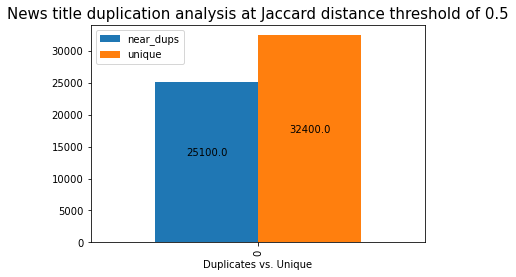

In [22]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind ='bar', y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis at Jaccard distance threshold of 0.5', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

Increasing the distance threshold to 0.5 (any pair of titles with a lower value are considered duplicates) has raised the number of duplicates from just over 20,000 (out of approximately 57,000) to 25,100. This isn't surprising, since we've made it harder to a pair of titles to be considered unique from each other. Still, the change in the split is not that siginificant.

Re-create histogram of near-duplication (I understood this to mean the following: a histogram showing distribution of Jaccard distance values for those pairs that were called dups by our algorithm).

In [23]:
df_dups_text.select('jacc_distance', 'text_id_A').dropDuplicates(['text_id_A']).count()

25100

In [24]:
jacc_dist_scores = df_dups_text.select('jacc_distance', 'text_id_A').dropDuplicates(['text_id_A']).toPandas()
jacc_dist_scores.head()

,jacc_distance,text_id_A
0,0.0,2214
1,0.0,2453
2,0.0,4590
3,0.0,7225
4,0.0,16896


In [25]:
jacc_dist_scores.shape

(25100, 2)

In [29]:
jacc_dist_scores.jacc_distance.describe()

count    25100.000000
mean         0.161818
std          0.173889
min          0.000000
25%          0.000000
50%          0.111111
75%          0.333333
max          0.481481
Name: jacc_distance, dtype: float64

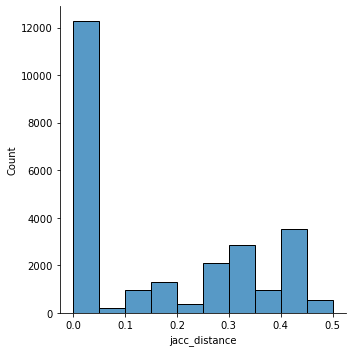

In [28]:
sns.displot(jacc_dist_scores, x='jacc_distance', binwidth=0.05)

Again, there are quite a few (almost half the total duplicate pairs) that have between 0.00 and 0.05 similarity score, meaning that they are or are very close to identical.